In [1]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import pybullet as p

os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append(os.path.join(os.path.abspath(os.getcwd()),".."))
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))


# import FERL Modules
from utils.learned_feature import LearnedFeature
from utils.plot_utils import *
from utils.environment_utils import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image

In [2]:
# Settings for the different cases
traces_file_cases = ["laptop", "table", "proxemics"]
participant_IDs = [0] #range(12)
traces_idx = np.arange(10).tolist()
resources_dir = parent_dir + "/data/resources/"

# Setup environment.
physicsClient = p.connect(p.DIRECT)
p.setAdditionalSearchPath(resources_dir)
objectID = setup_environment()
p.setGravity(0, 0, 0)
p.setRealTimeSimulation(1)

# settings for the learned feature (27D Euclidean Feature Space)
LF_dict = {'bet_data':5, 'sin':False, 'cos':False, 'rpy':False, 'lowdim':False, 'norot':True,
           'noangles':True, '6D_laptop':False, '6D_human':False, '9D_coffee':False, 'EErot':False,
           'noxyz':False, 'subspace_heuristic':False}

In [4]:
# Setting for which Case (see paper)
case = 1

In [5]:
# Step 1: load feature traces & initialize a learnable feature
unknown_feature = LearnedFeature(2, 64, LF_dict)

data_file = parent_dir + '/data/user_data/{}_{}.p'.format(participant_IDs[0], traces_file_cases[case-1])
trajectory_list = pickle.load(open( data_file, "rb" ) )

all_trace_data = np.empty((0, 97), float)
for idx in traces_idx:
    np.flip(trajectory_list[idx],axis=0)
    unknown_feature.add_data(trajectory_list[idx])
    all_trace_data = np.vstack((all_trace_data, trajectory_list[idx]))

In [6]:
# Step 2: train the feature on the set of traces
_ = unknown_feature.train(epochs=100, batch_size=32, learning_rate=1e-3, weight_decay=0.001, s_g_weight=10.)

epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]

Select subspace training, testing on 5 unseen Trajectory
len train:  5929
len test:  4696
No subspace selection performed.
Train subspace model 0 on all 10 Trajectories


epoch 99: 100%|██████████| 100/100 [01:49<00:00,  1.09s/it, train_loss=0.434]

Final model trained!


# Viz learned feature

In [34]:
viz_learned_feat(parent_dir, traces_file_cases[case-1], objectID, unknown_feature)

/Users/mariuswiggert/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning:

invalid value encountered in true_divide



# VIZ GT Feature

In [44]:
case = 3

/Users/mariuswiggert/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning:

invalid value encountered in true_divide




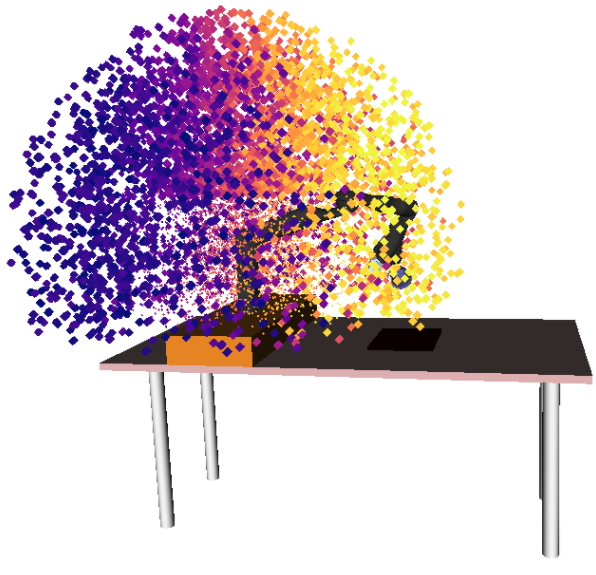

In [45]:
viz_gt_feature(parent_dir, traces_file_cases[case-1], objectID)

# Functions needed

In [ ]:
def viz_gt_feature(parent_dir, feat, objectID):
    # get 3D plot traces
    proj_surface, gt_ball = get_3D_plot(parent_dir, feat, objectID, offset = -0.2)

    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "xy"}, {"type": "scene"}]],
        subplot_titles=[
            'Feature Visualization in Space', 
            '3D Visualization & Projection'
        ]
    )


    # plot image
    fig.add_trace(px.imshow(Image.open(parent_dir + '/data/images/{}_3D.png'.format(feat))).data[0], row=1, col=1)

    # plot 3D and projection
    fig.add_trace(gt_ball, row=1, col=2)
    fig.add_trace(proj_surface, row=1, col=2)

    fig.update_layout(
        yaxis=dict(showticklabels=False),
        xaxis=dict(showticklabels=False)
    )
    fig.show()
    return

In [40]:
def get_3D_plot(parent_dir, feat, objectID, offset = -0.2, func=None):
    # load data
    data_file = parent_dir + '/data/gtdata/data_{}.npz'.format(feat)
    npzfile = np.load(data_file)
    train_data = npzfile['x']
    euclidean = angles_to_coords(npzfile['x'][:,:7], feat, objectID)
    # make z axis 0
    euclidean[:,2] = euclidean[:,2] - euclidean[:,2].min()

    if func is None: # do GT labels
        labels = npzfile['y']
    else: # calculate with learned values
        output = func(train_data)
        labels = output.reshape(-1)

    # scale labels to 0-1
    labels = labels - labels.min()
    labels = labels/labels.max()
        
    # plotting settings
    proj_res = 50

    # plot the GT ball
    gt_ball=go.Scatter3d(x=euclidean[:,0], y=euclidean[:,1], z=euclidean[:,2], mode='markers',
                         marker=dict(color=labels, showscale=True), showlegend=False)

    # create projection of gt
    proj_surface = get_projection_trace(euclidean, labels, feat, offset, proj_res)
    
    return proj_surface, gt_ball

In [23]:
def get_projection_trace(euclidean, labels, feat, offset, proj_res=50):
    
    # get scale so that outside is gray
    val_list = [0., 0.01, 0.01, 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.]  
    col_list = ['gray', 'gray'] + px.colors.sequential.Plasma
    scale = [[val_list[i], col_list[i]] for i in range(len(col_list))]

    # check which axis to project onto
    if feat in ['laptop', 'proxemics']: #xy
        idx_1 , idx_2, idx_proj = 0, 1, 2
    else: # yz
        idx_1 , idx_2, idx_proj = 1, 2, 0

    # calculate range of the matrix
    idx_1_min, idx_1_max = euclidean[:,idx_1].min() - 0.1, euclidean[:,idx_1].max() + 0.1
    idx_2_min, idx_2_max = euclidean[:,idx_2].min() - 0.1, euclidean[:,idx_2].max() + 0.1

    # calculate matrix
    proj_matrix = np.zeros((proj_res, proj_res))
    counts = np.zeros((proj_res, proj_res))
    idx_1_space = np.linspace(idx_1_min, idx_1_max, proj_res + 1)
    idx_2_space = np.linspace(idx_2_min, idx_2_max, proj_res + 1)
    for i in range(euclidean.shape[0]):
        if feat in ['laptop', 'proxemics']: #xy
            temp_idx_2 = np.searchsorted(idx_1_space, euclidean[i, idx_1])
            temp_idx_1 = np.searchsorted(idx_2_space, euclidean[i, idx_2])
            proj_matrix[-(proj_res-temp_idx_1-1)][temp_idx_2] += labels[i]
            counts[-(proj_res-temp_idx_1-1)][temp_idx_2] += 1
        else: # yz
            temp_idx_1 = np.searchsorted(idx_1_space, euclidean[i, idx_1])
            temp_idx_2 = np.searchsorted(idx_2_space, euclidean[i, idx_2])
            proj_matrix[temp_idx_2][proj_res-temp_idx_1-1] += labels[i]
            counts[temp_idx_2][proj_res-temp_idx_1-1] += 1
    proj_matrix /= counts

    # normalize
    proj_matrix = proj_matrix/np.nanmax(proj_matrix)
    proj_matrix[np.isnan(proj_matrix)] = -0.05
#     proj_matrix[~np.isnan(proj_matrix)] = proj_matrix[~np.isnan(proj_matrix)] + 0.08

    # make it plotable as surface
    idx_1_matrix, idx_2_matrix=np.meshgrid(np.linspace(idx_1_min, idx_1_max, proj_res),
                                           np.linspace(idx_2_min, idx_2_max, proj_res))
    proj_cord_offset=(offset + euclidean[:,idx_proj].min())*np.ones(proj_matrix.shape)

    # create the trace
    if feat in ['laptop', 'proxemics']: #xy
        proj_surface = go.Surface(z=proj_cord_offset,
                              x=idx_1_matrix,
                              y=idx_2_matrix,
                                colorscale= scale,
                              showscale=False,
                              surfacecolor=proj_matrix,
#                                   opacity = 0.9
                             )
    else: # yz
        proj_surface = go.Surface(z=idx_2_matrix,
                              x=proj_cord_offset,
                              y=idx_1_matrix,
                                  colorscale= scale,
                              showscale=False,
                              surfacecolor=proj_matrix,
#                                   opacity = 0.9
                             )
    return proj_surface

In [33]:
def viz_learned_feat(parent_dir, feat, objectID, learned_feature):

    # get learned 3D & projection
    proj_surface, gt_ball = get_3D_plot(parent_dir, feat,
                                        objectID, offset = -0.2, func=learned_feature.function)

    fig = make_subplots(
        rows=1, cols=2,
        specs=[[{"type": "scene"}, {"type": "scene"}]],
        subplot_titles=[
            'Traces in 3D Space', 
            '3D Visualization & Projection of learned Feature'
        ]
    )

    # plot traces
    trace_euclidean = angles_to_coords(all_trace_data[:, :7], feat, objectID)
    trace_labels = learned_feature.function(all_trace_data)
    traces=go.Scatter3d(x=trace_euclidean[:,0], y=trace_euclidean[:,1], z=trace_euclidean[:,2], mode='markers',
                                      marker=dict(color=trace_labels.reshape(-1), showscale=False), showlegend=False)
    fig.add_trace(traces, row=1, col=1)

    # plot 3D and projection
    fig.add_trace(gt_ball, row=1, col=2)
    fig.add_trace(proj_surface, row=1, col=2)

    fig.update_layout(
        yaxis=dict(showticklabels=False),
        xaxis=dict(showticklabels=False)
    )
    fig.show()
    
    return 